# Hands-on ML with Python
# Chapter 3 - MNIST Classification

## Setup

In [1]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# Make this notebook's output stable across runs
np.random.seed(42)

# Plotting figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt 
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Saving figures 
ROOT_DIR = "."
IMAGES_PATH = os.path.join(ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

In [45]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function to save figures
def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." +  fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Fetching MNIST 
Helper functions to download and import commonly used ML datasets such as MNIST are built into `sklearn`.

In [3]:
# This may take some time
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

Datasets downloaded by `sklearn` have a dictionary structure with key-value pairs for a description of the dataset (`DESCR`), the actual data for the dataset (`data`), and labels/targets for the data (`target`).

In [7]:
# Extracting features and labels
X, y = mnist['data'], mnist['target']

In [8]:
# Examine shape of the features
X.shape

(70000, 784)

In [9]:
# Examine shape of the labels
y.shape

(70000,)

There are 70k arrays of 784 pixel values, which are formed by concatenating the pixel intensity values of a 28px by 28px image end to end.

## Examining a Single Digit

In [28]:
import matplotlib as mpl
import matplotlib.pyplot as plt

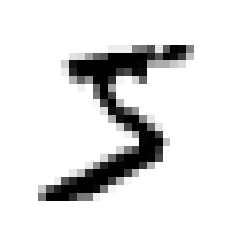

In [29]:
# Features (pixel intensity values) of the first sample in the dataset
some_digit = X[0]

# 1D vector to 2D array of the same size as the original image
some_digit_image = some_digit.reshape(28, 28)

# Render it
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [12]:
# The label for this sample is also 5, although it is a string
y[0]

'5'

In [13]:
# Converting all string labels to int labels for later
y = y.astype(np.uint8)

In [4]:
# Creating a row of digit images

In [14]:
def plot_digits(instances, images_per_row=10, **options):
    """Plots a list digit images in a grid"""
    # width/height of a single image
    size = 28
    
    # Number of images per row is either the total number of instances (in which case all images will be displayed in a single line)
    # or the `images_per_row` argument
    # The images to be displayed in each row will be the smaller of these values
    images_per_row = min(len(instances), images_per_row)
    
    # Reshape all images to a square using list comprehension
    images = [instance.reshape(size, size) for instance in instances]
    
    # One extra row?
    n_rows = (len(instances) - 1) // images_per_row + 1
    # Empty list to store the images for each row
    row_images = []
    
    # Number of empty cells in the grid of images
    n_empty = n_rows * images_per_row - len(instances)
    
    # Add empty cells to the reshaped np arrays
    images.append(np.zeros((size, size * n_empty)))
    
    # For each row in the grid
    for row in range(n_rows):
        # Add pixel values for each successive row
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
        
    # The grid of images will be a single image
    image = np.concatenate(row_images, axis=0)
    
    # Plot the grid with the keyword arguments for plotting passed as **options
    plt.imshow(image, cmap=mpl.cm.binary, **options)
    
    # Don't display the axis
    plt.axis('off')

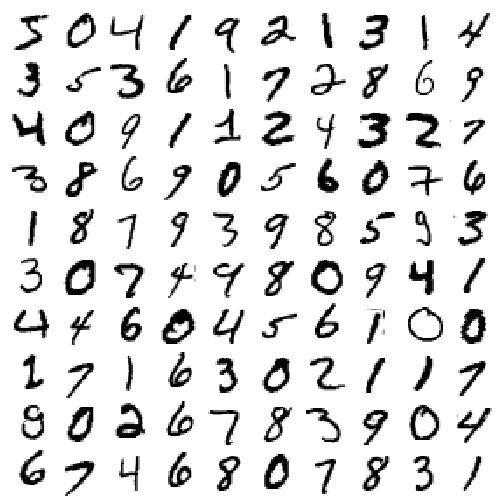

In [15]:
plt.figure(figsize=(9, 9))
example_images = X[:100] 
plot_digits(example_images, images_per_row=10)
plt.show()

## Train-Test Split
MNIST dataset is already split: first 60k are training images and last 10k are test images. The training set is already shuffled so all cross-validation folds will be similar.

In [20]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

But is the training set also stratified? As in, is there a proportional representation of all classes in the training set?

In [21]:
import pandas as pd 
pd.DataFrame(y_train)[0].value_counts()

1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: 0, dtype: int64

Roughly the same, although there is a lot of disparity between 5 and 1. Maybe this is representative of the entire data set?

## Training Binary Classifier
Differentiating between only two classes: digits that are `5` and those that are not. 

In [35]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

Using Stochastic Gradient Descent because it can handle very large datasets, and trains the entire model's weights based on a single randomly drawn sample at a time. 

In [36]:
from sklearn.linear_model import SGDClassifier

In [37]:
# Must seed the random state so that it draws the same samples across all runs
sgd_clf = SGDClassifier(random_state=42)

In [38]:
# Fit the classifier to the training data
sgd_clf.fit(X_train, y_train_5)

/Users/saadmashkoor/.local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [39]:
sgd_clf.predict([some_digit])

array([False])

In [40]:
from sklearn.metrics import confusion_matrix

In [41]:
conf_mat = confusion_matrix(y_train_5, sgd_clf.predict(X_train))

In [34]:
print(conf_mat)

[[54273   306]
 [ 1850  3571]]


## Custom Cross Validation

In [46]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [47]:
skfolds = StratifiedKFold(n_splits=3, random_state=42)

In [48]:
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) 

0.9532
0.95125
0.9625


Stratified K-fold sampling performs stratified sampling to ensure that all classes in the sampled training sets are represented proportionally to their presence in the entire dataset. More specifically, it performs stratified sampling to create `n_splits` sections or folds in the dataset. For each split, a different subsection of the dataset is used as the test set, while all others are used as training set. This ensures that each subset or fold of the dataset is used as a test set at least once, and that any sampling noise/bias is eliminated.

A `clone` of the classifier is created for each training/prediction cycle. 

Finally, the correct number of predictions are counted and expressed as a proportion of the total predictions.

In [49]:
from sklearn.model_selection import cross_val_score

In [50]:
cross_val_score(sgd_clf, X_train, y_train_5, 
               cv=3, scoring='accuracy')

array([0.9532 , 0.95125, 0.9625 ])

There are three different scores because we trained three different versions of the `sgd` classifier. Each was trained and then tested on separate subsets of the dataset.

## Comparing with a Random Estimator
Before we can assess whether the 95%+ classification accuracy is satisfactory, we need to establish a baseline. The baseline is a **random estimator**: an estimator that will predict `not-5` for every sample.

In [51]:
from sklearn.base import BaseEstimator

In [52]:
class Never5Classifier(BaseEstimator):
    """A classifier that will not optimise any weights and will just predict `not-5` for all samples."""
    def fit(self, X, y=None):
        # Will not do any training
        pass 
    
    def predict(self, X):
        """For each sample of training data, predict 0"""
        return np.zeros((len(X), 1), dtype=bool)

In [53]:
# Instantiate the random classifier
never_5_clf = Never5Classifier()

In [54]:
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

The random classifier has, on average, a 90%+ accuracy. This is because since only 10% of all samples in the dataset are `5`, then predicting `not-5` every time without even looking at the image, we will still be able to get 90%+ accuracy. 

This shows that accuracy is not a good performance metric for skewed datasets (datasets in which some classes are much more frequent than others).

## Confusion Matrix
Shows the true positives, true negatives, false positives, and false negatives predicted by a classifier. A much better way of evaluating a classifier's performance, especially for skewed datasets, because it shows the **proportion** of correctly identified classes relative to others.

In [55]:
from sklearn.model_selection import cross_val_predict

In [56]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

`cross_val_predict` returns the predictions made by each classifier on its own test fold i.e. a clean prediction - one made on data that the classifier did not see during training.

The final predicted class label is the label predicted by majority of folds.

In [62]:
from sklearn.metrics import confusion_matrix

In [64]:
confusion_matrix(y_train_5, y_train_pred)

array([[52992,  1587],
       [ 1074,  4347]])

- Each row is the actual class in a dataset, and each column is the predicted class.
- First row/col is for class 0 and second row/col is for class 1.
- In this case, class 0 (the negative class or non-target class) represents digits that are not 5.
- 52,992: TNs: True Negatives: Predicted 0, actual 0
- 1587: FPs: False Positives: Predicted 1, actual 0 
- 1074: FN: False Negatives: Predicted 0, actual 1
- 4347: TPs: True Positives: Predicted 1, actual 1

In [65]:
# Hypothetical perfect classifier? Predicted = actual
y_train_perfect_predictions = y_train_5 

In [66]:
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

Precision = TP / (TP + FP)


Recall = TP / (TP + FN)
Aka sensitivity, true positive rate. Ratio of positive instances that are correctly identified by classifier.

## Computing Precision/Recall

In [68]:
from sklearn.metrics import precision_score, recall_score

In [69]:
precision_score(y_train_5, y_train_pred)

0.7325581395348837

In [70]:
recall_score(y_train_5, y_train_pred)

0.8018815716657444

This means that when the classifier predicts a 5, it is correct only 73% of the time. Furthermore, it only identifies 80% of all 5s in the dataset.

This shows how a cross val score of 95% (achieved earlier) was not really indicative of the classifier's performance.

## F1 Score
The F1 score is the harmonic mean of the precision and recall. It gives much more weight to low values. The F1 score will therefore only be high only if both precision and recall are high.

$$F1 = 2 \times \frac{P \times R}{P + R}$$
Alternatively, 
$$F1 = \frac{TP}{TP + \frac{FN + FP}{2}}$$

In [71]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.765653896961691